# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [12]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [13]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [14]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()
#df_transactions.groupby(['customer_name', 'offer_id']).count().unstack(['offer_id'])

#len(df_transactions.customer_name.unique()) #100 unique customers. 
#len(df_transactions.offer_id.unique()) #32 unique offers

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [15]:
#your turn
import numpy as np
new_df=df_transactions.merge(df_offers, left_on='offer_id', right_on='offer_id').drop(['campaign', 'min_qty','varietal','origin','past_peak','discount'], axis=1)
new_df
offer_redeem = pd.pivot_table(new_df, values='n', index=['customer_name'],
                    columns=['offer_id'], fill_value=0,aggfunc=np.sum)
offer_redeem.head()
df_pca=offer_redeem
df_pca_story=offer_redeem

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Excercise Set II - Solution
1. SS should be close to zero for better cluster representations
2. See code below for x_cols array
3. See graph below. I will pick K=7 or 8 as it appears to have less inertia changes after that point
4. See graph below
5. I didn't see any specific place on the graph (SS vs K) where an "elbow" or "knee" could be seen very clearly. Therefore gussing K to the best of what I could see. 




In [16]:
df=offer_redeem.reset_index()

x_cols=df.drop(['customer_name'], axis=1)
x_cols=x_cols.to_numpy()
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

Text(0, 0.5, 'Inertia/Sum of Squares')

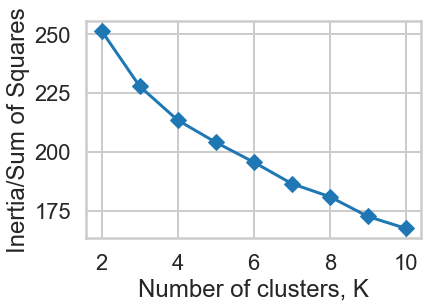

In [17]:
from sklearn.cluster import KMeans

inertia=[]

for k in range(2,11,1):
    model=KMeans(n_clusters=k, random_state=42)
    model.fit(x_cols)
    inertia.append(model.inertia_)
    
#inertia = Sum of squared distances of samples to their closest cluster center.

plt.plot(range(2,11,1),inertia, marker='D')
plt.xlabel('Number of clusters, K')
plt.ylabel('Inertia/Sum of Squares')
#plt.ylim([150,280])

Text(0, 0.5, 'Number of points')

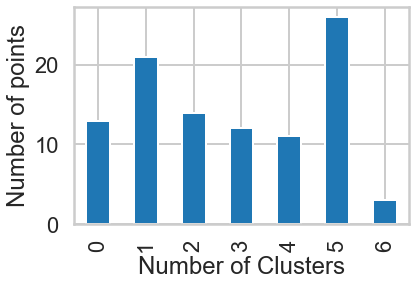

In [18]:
bestK=KMeans(n_clusters=7, random_state=42)
bestK.fit(x_cols)
y_pred=bestK.predict(x_cols)
value=pd.value_counts(y_pred)

NumPerK_df=pd.DataFrame(value, columns=['number of points'])
NumPerK_df.sort_index().plot(kind='bar', legend=False)
plt.xlabel('Number of Clusters')
plt.ylabel('Number of points')


#################################################################

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

 Exercise Set III - Solution:
 1. Graphs - see below
 2. All sihouette scores are below. 
 For n_clusters = 9 The average silhouette_score is : 0.141786
 Looks like K=9 gives best score. However it is still under 0.25 which means there isn't no substantial structure here. 
 3. The line plot also shows that maximum score is at K=9 and this is different conclusion from the knee-elbow plot above.

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193


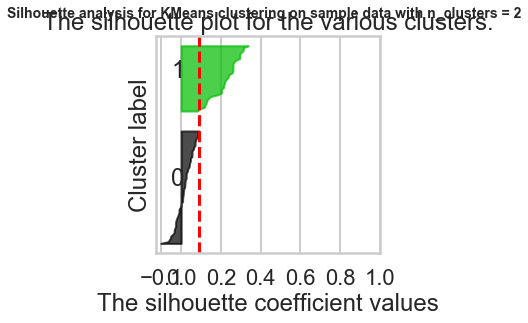

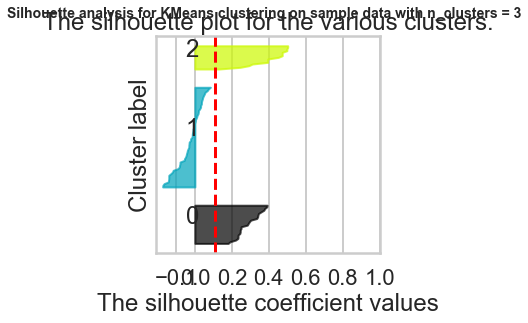

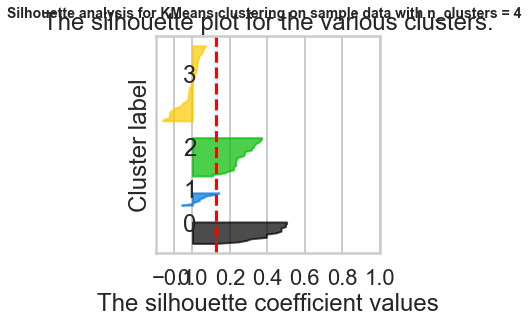

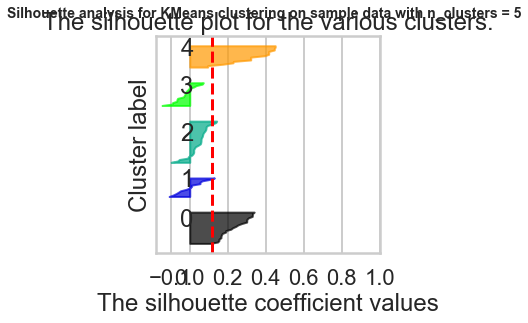

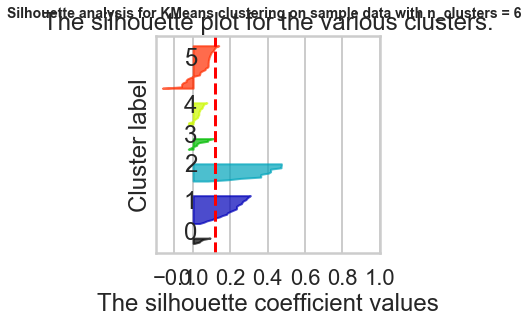

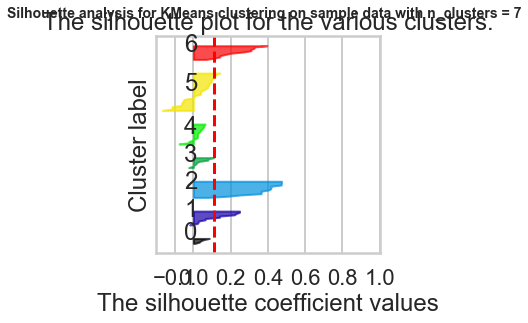

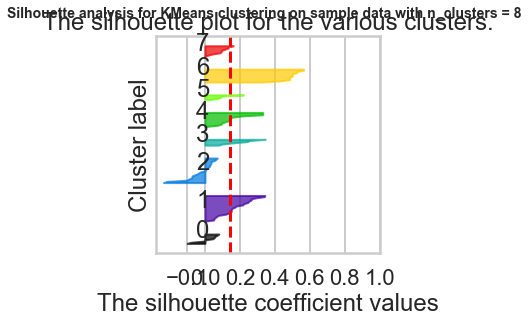

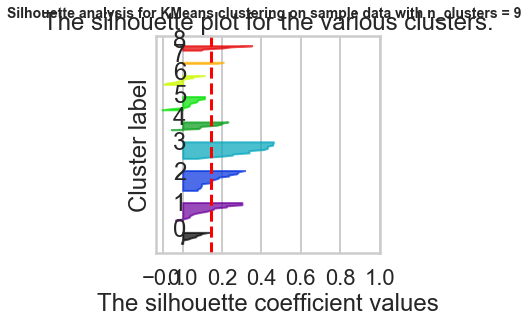

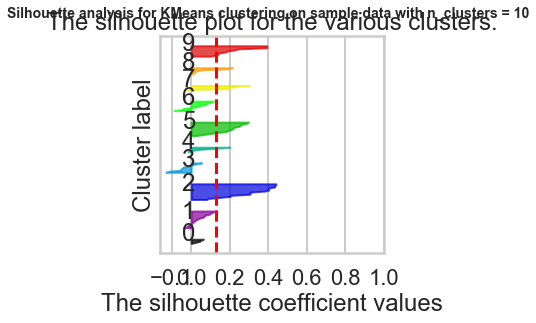

In [24]:
# Your turn.
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]
score=[]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # Initialize the clusterer with n_clusters value and a random generator seed = 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Compute the silhouette scores for each sample
    silhouette_avg = sklearn.metrics.silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    score.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)


    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx((np.arange(y_lower, y_upper)),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Text(0.5, 1.0, 'Average Silhouette Score vs Number of Cluster')

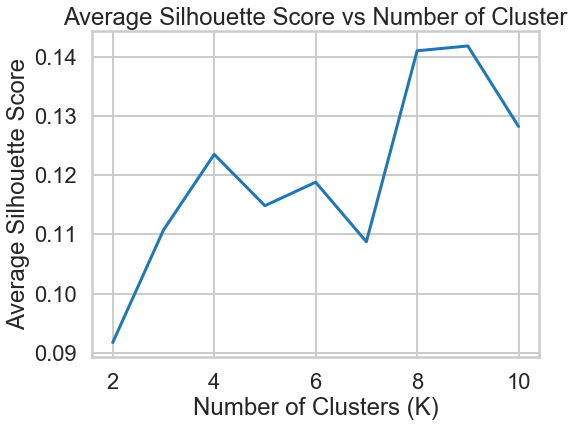

In [25]:
plt.figure(figsize=(8,6))
plt.plot(range_n_clusters, score)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.title("Average Silhouette Score vs Number of Cluster")

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

#### Exercise Set IV - Solution
1. See code below
2. plotted scatter plot for x and y for K=7 and K=9 (K gotten from knee-elbow method and from silhouette method)
.... both scatter plots do not show me any specific boundaries
3. Plotted scatter plots for all K's between 2 and 10. Looking at K=3 scatter graph seems like the best boundaries 
4. None of the methods above produced K=3 which I think is the best K based on visually inspecting graphs



Text(0.5, 1.0, 'scatter plot with 9 clusters (K=9)')

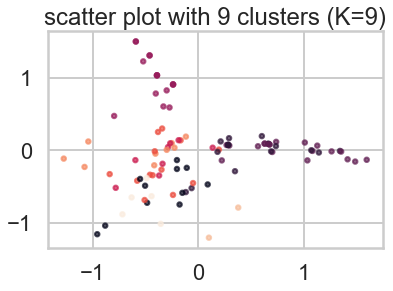

In [494]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

# # Fit_predict with KMeans (K=9 from Silhouette method)
cluster_9 = KMeans(n_clusters=9, random_state=10)

# # Broadcast 'cluster' column to existing pivot table dataframe
offer_redeem['predicted_clusters_9'] = cluster_9.fit_predict(x_cols)
offer_redeem['x']=pca.fit_transform(x_cols)[:,0]
offer_redeem['y']=pca.fit_transform(x_cols)[:,1]

plt.scatter(offer_redeem['x'], offer_redeem['y'], s=20, alpha=0.7,c=offer_redeem.predicted_clusters_9)
plt.title('scatter plot with 9 clusters (K=9)')

offer_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,predicted_clusters_9,x,y,predicted_clusters_7
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,2,1.007580,0.108215,1
Allen,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,4,-0.287539,0.044715,5
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,-0.392032,1.038391,2
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,2,0.699477,-0.022542,6
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0.088183,-0.471695,5


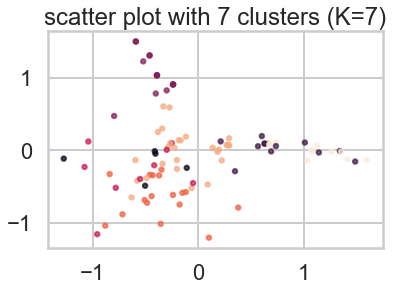

In [495]:
#K=7 (from knee elbow method)

pca = PCA(n_components = 2)

# # Fit_predict with KMeans (K=7 from Silhouette method)
cluster_7 = KMeans(n_clusters=7, random_state=10)

# # Broadcast 'cluster' column to existing pivot table dataframe
offer_redeem['predicted_clusters_7'] = cluster_7.fit_predict(x_cols)

# Scatter plot for K=7
plt.scatter(offer_redeem['x'], offer_redeem['y'], s=20, alpha=0.7,c=offer_redeem.predicted_clusters_7)
plt.title('scatter plot with 7 clusters (K=7)')

offer_redeem.head()

In [497]:
#Many K values

k_values = list(range(2, 11))

for k in k_values: 
    kmeans = KMeans(n_clusters=k, random_state = 15)
    k_pred_array = kmeans.fit_predict(x_cols)
    df_pca['cluster_' + str(k)] = k_pred_array

df_pca.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,predicted_clusters_7,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,1,1,1,2,2,3,2,1,1,6
Allen,0,0,0,0,0,0,0,0,1,0,...,5,0,2,1,0,5,1,3,8,1
Anderson,0,0,0,0,0,0,0,0,0,0,...,2,0,0,3,1,1,5,4,4,4
Bailey,0,0,0,0,0,0,1,0,0,0,...,6,1,1,2,2,3,3,1,2,2
Baker,0,0,0,0,0,0,1,0,0,1,...,5,0,2,1,0,4,4,2,2,2


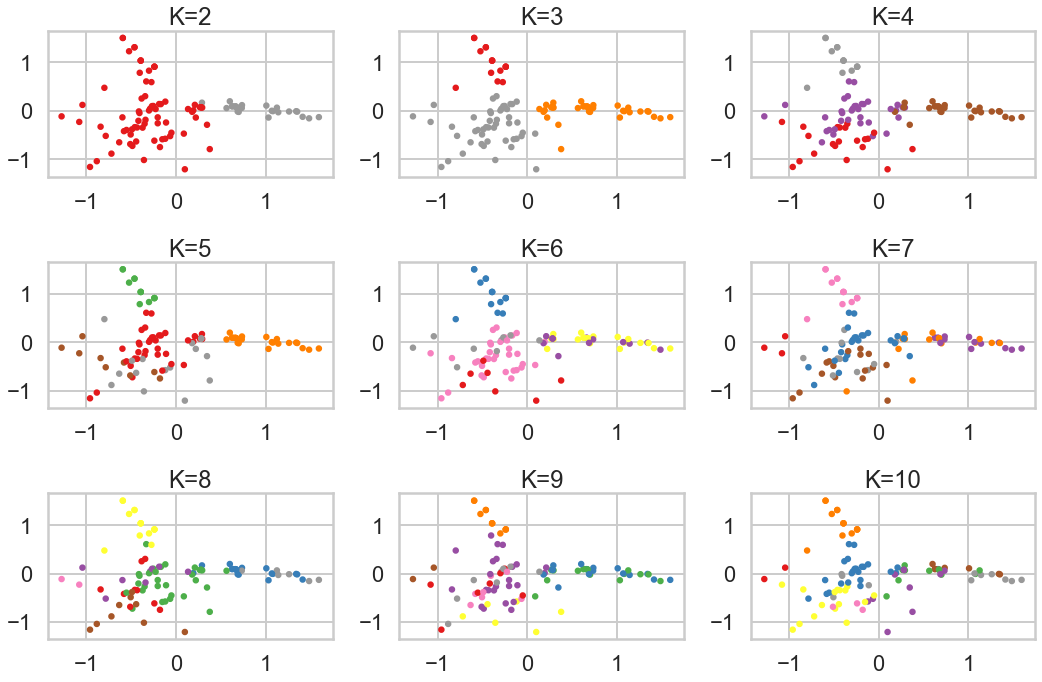

In [498]:
df_pca['x']=pca.fit_transform(x_cols)[:,0]
df_pca['y']=pca.fit_transform(x_cols)[:,1]
###################################################
k_values = list(range(2, 11))
fig,axes=plt.subplots(3,3, figsize=(15,10))

for i, k in enumerate(k_values):
    xk=i//3
    yk=i%3
    
    axes[xk][yk].scatter(df_pca['x'], df_pca['y'], c=df_pca['cluster_'+str(k)], s=20, cmap='Set1')
    axes[xk][yk].set_title("K=" +str(k))
plt.tight_layout()

#### Exercise: 

Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

In [499]:
df_story.head()

offer_id,cluster_3,cluster_7,x,y
customer_name,,,,
Adams,1,2,1.007580,0.108215
Allen,2,1,-0.287539,0.044715
Anderson,0,5,-0.392032,1.038391
Bailey,1,3,0.699477,-0.022542
Baker,2,4,0.088183,-0.471695


In [500]:
df_offers.head()

df_merged=pd.merge(df_transactions, df_offers, on='offer_id')
df_merged.head()

df_merged_story=pd.merge(df_merged,df_story, on='customer_name')
df_merged_story.head()

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster_3,cluster_7,x,y
0,Smith,2,1,January,Pinot Noir,72,17,France,False,0,5,-0.300227,0.829765
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,0,5,-0.300227,0.829765
2,Rodriguez,2,1,January,Pinot Noir,72,17,France,False,0,5,-0.403273,0.786296
3,Rodriguez,26,1,October,Pinot Noir,144,83,Australia,False,0,5,-0.403273,0.786296
4,Martin,2,1,January,Pinot Noir,72,17,France,False,2,6,-0.382241,0.254034


<Figure size 1080x1080 with 0 Axes>

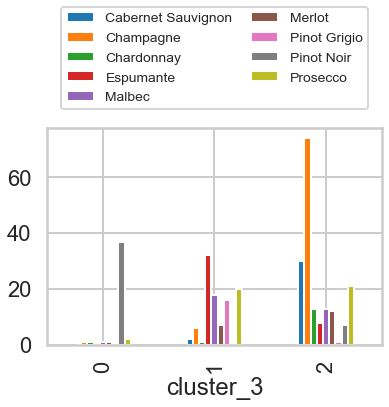

In [501]:
crosstab_varietal = pd.crosstab(df_merged_story['cluster_3'], df_merged_story['varietal'])
plt.figure(figsize=(15,15))

crosstab_varietal.plot(kind='bar')

#plt.legend(bbox_to_anchor=(1.1, 1), loc='lower left', borderaxespad=0.)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", fontsize='xx-small',borderaxespad=1)


In [502]:
grp_by_customer=df_merged_story.groupby(['cluster_3', 'customer_name']).count()
grp_by_customer.loc[0].shape, grp_by_customer.loc[1].shape, grp_by_customer.loc[2].shape

((16, 11), (37, 11), (47, 11))

#### Data Story

1. With three clusters a better patterns has emerged. Seems like customer in group 0 (almost all 16 of them) prefer Pinot Noir. 

2. Group 2 seems to prefer Champagne the most. However this group has most diverse in their preference too.This group seems to buy the most 

3. Group 1 seems to have diverese preference but also are not very big on buying alot. 


##### For the upcoming campaigns I would target group 2 customers with incentives on champagne the most. 

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

#### Exercise Set V - Solution
1. See the graph below

2. From the graph the knee or elbow is around 3 or could be 4. Therefore the optimal dimenstions could be 4???

Text(0.5, 1.0, 'Explained Variance vs Dimensions of the Wine Data')

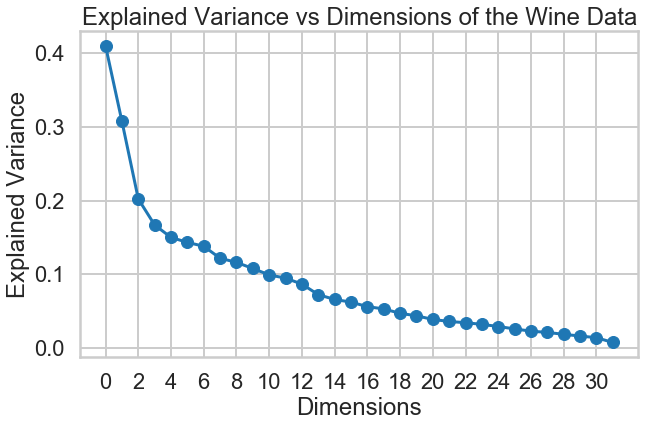

In [503]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
#pca.fit(x_cols)
pred=pca.fit_transform(x_cols)
#pred[:,0], pred[:,1]

EV=pca.explained_variance_
plt.figure(figsize=(10,6))
plt.plot(range(len(EV)), EV, marker='o')
plt.xticks(range(0,32,2))
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Dimensions of the Wine Data')


## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


##### Affinity propagation
From https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#:~:text=AffinityPropagation,-class%20sklearn.cluster&text=Perform%20Affinity%20Propagation%20Clustering%20of%20data.&text=Damping%20factor%20(between%200.5%20and,updating%20these%20values%20(messages)

### NO IDEA what this means :(

. AffinityPropagation. Perform Affinity Propagation Clustering of data. Damping factor (between 0.5 and 1) is the extent to which the current value is maintained relative to incoming values (weighted 1 - damping). This in order to avoid numerical oscillations when updating these values (messages).


In [567]:
all_scores={}

from sklearn.cluster import AffinityPropagation
damping_factors=np.linspace(0.5,1,10, endpoint=False)

best_score=0

for d in damping_factors:
    af=AffinityPropagation(damping=d, random_state=None)
    ap_cluster = af.fit_predict(x_cols)
    sil_avg_score = silhouette_score(x_cols, ap_cluster, random_state = 10)
    
    print("For damping value of: {:0.2f}, the silhouette score is: {:0.3f}".format(d, sil_avg_score))
    
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        best_damping = d
    
print("Best damping parameter: {:0.2f}, Best Silhouette score {:0.2f}".format(best_damping, best_score))

all_scores['AF']=str(round(best_score, 2))

For damping value of: 0.50, the silhouette score is: 0.123
For damping value of: 0.55, the silhouette score is: 0.127
For damping value of: 0.60, the silhouette score is: 0.125
For damping value of: 0.65, the silhouette score is: 0.129
For damping value of: 0.70, the silhouette score is: 0.119
For damping value of: 0.75, the silhouette score is: 0.122
For damping value of: 0.80, the silhouette score is: 0.090
For damping value of: 0.85, the silhouette score is: 0.092
For damping value of: 0.90, the silhouette score is: 0.092
For damping value of: 0.95, the silhouette score is: 0.112
Best damping parameter: 0.65, Best Silhouette score 0.13


### Spectral Clustering

In [568]:
from sklearn.cluster import SpectralClustering


n_clusters = list(range(2, 11))

best_score = 0

for k in n_clusters:
    sc = SpectralClustering(n_clusters=k, random_state=10)
    sc_cluster = sc.fit_predict(x_cols)
    sil_avg_score = silhouette_score(x_cols, sc_cluster, random_state = 15)
    
    print("For n_cluster of: {:0.0f}, the silhouette score is: {:0.3f}".format(k, sil_avg_score))
    
    if sil_avg_score > best_score:
        best_score = sil_avg_score  # Update with the best silhouette score
        optimal_cluster = k
        
print("\nOptimized number of clusters is: {:0.0f}, with a silhouette score of: {:0.3f}".format(optimal_cluster, best_score))
all_scores["Spectral"] = str(round(best_score, 2))

For n_cluster of: 2, the silhouette score is: 0.076
For n_cluster of: 3, the silhouette score is: 0.106
For n_cluster of: 4, the silhouette score is: 0.086
For n_cluster of: 5, the silhouette score is: 0.100
For n_cluster of: 6, the silhouette score is: 0.095
For n_cluster of: 7, the silhouette score is: 0.075
For n_cluster of: 8, the silhouette score is: 0.091
For n_cluster of: 9, the silhouette score is: 0.091
For n_cluster of: 10, the silhouette score is: 0.089

Optimized number of clusters is: 3, with a silhouette score of: 0.106


#### Agglomerative Clustering

Recursively merges the pair of clusters that minimally increases a given linkage distance.

class sklearn.cluster.AgglomerativeClustering(n_clusters=2, *, affinity='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None

In [569]:
from sklearn.cluster import AgglomerativeClustering

# # Hyperparameter Tuning
linkage= ['ward', 'complete', 'average', 'single']
n_clusters=[2,3,4,5,6,7,8,9,10]



best_score = 0

for n in n_clusters:
    for i in range(len(linkage)):
        ac = AgglomerativeClustering(n_clusters=n, linkage=linkage[i])
        ac_cluster = ac.fit_predict(x_cols)
        sil_avg_score = silhouette_score(x_cols, ac_cluster, random_state = 15)
    
        print("For k='{}' and linkage method: '{}', the silhouette score is: {:0.3f}".format(n, linkage[i], sil_avg_score))
    
        if sil_avg_score > best_score:
            best_score = sil_avg_score  # Update with the best silhouette score
            optimal_strategy = linkage[i]
            best_cluster=n
        
print("For clusters of: '{}', Optimized linkage is: '{}', with a silhouette score of: {:0.3f}".format(best_cluster, optimal_strategy, best_score))
all_scores["Agglomerative"] = str(round(best_score, 2))

For k='2' and linkage method: 'ward', the silhouette score is: 0.083
For k='2' and linkage method: 'complete', the silhouette score is: 0.235
For k='2' and linkage method: 'average', the silhouette score is: 0.214
For k='2' and linkage method: 'single', the silhouette score is: 0.279
For k='3' and linkage method: 'ward', the silhouette score is: 0.116
For k='3' and linkage method: 'complete', the silhouette score is: 0.056
For k='3' and linkage method: 'average', the silhouette score is: 0.190
For k='3' and linkage method: 'single', the silhouette score is: 0.171
For k='4' and linkage method: 'ward', the silhouette score is: 0.129
For k='4' and linkage method: 'complete', the silhouette score is: 0.050
For k='4' and linkage method: 'average', the silhouette score is: 0.161
For k='4' and linkage method: 'single', the silhouette score is: 0.165
For k='5' and linkage method: 'ward', the silhouette score is: 0.141
For k='5' and linkage method: 'complete', the silhouette score is: 0.081
For

#### DBSCAN
class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)


In [570]:
from sklearn.cluster import DBSCAN

algo=['auto', 'ball_tree', 'kd_tree', 'brute']
min_samples=[1,2,3]
best_score=0

for algo in algo:
    for i in min_samples:
        db=DBSCAN(min_samples=i, algorithm=algo)
        db_cluster=db.fit_predict(x_cols)
        sil_avg_score=silhouette_score(x_cols, db_cluster, random_state=10)
        
        print("For algo of:{} and min_sample size of {}, sil score was: {}".format(algo, i, sil_avg_score))
        if sil_avg_score > best_score:
            best_score = sil_avg_score  # Update with the best silhouette score
            best_min_sample = i
            best_algo=algo
print("The best score is: {}, for best min samples of: {}, with best algo:{}".format(best_score, best_min_sample, best_algo))
all_scores['DBSCAN']=str(round(best_score, 2))

        

For algo of:auto and min_sample size of 1, sil score was: 0.19
For algo of:auto and min_sample size of 2, sil score was: -0.021678059481408066
For algo of:auto and min_sample size of 3, sil score was: -0.10663555825496372
For algo of:ball_tree and min_sample size of 1, sil score was: 0.19
For algo of:ball_tree and min_sample size of 2, sil score was: -0.021678059481408066
For algo of:ball_tree and min_sample size of 3, sil score was: -0.10663555825496372
For algo of:kd_tree and min_sample size of 1, sil score was: 0.19
For algo of:kd_tree and min_sample size of 2, sil score was: -0.021678059481408066
For algo of:kd_tree and min_sample size of 3, sil score was: -0.10663555825496372
For algo of:brute and min_sample size of 1, sil score was: 0.19
For algo of:brute and min_sample size of 2, sil score was: -0.021678059481408066
For algo of:brute and min_sample size of 3, sil score was: -0.10663555825496372
The best score is: 0.19, for best min samples of: 1, with best algo:auto


In [571]:
all_scores

{'AF': '0.13', 'Spectral': '0.11', 'Agglomerative': '0.28', 'DBSCAN': '0.19'}

### Analysis

Looks like Agglomerative's silhouette score is the best among all. Although the score is not too high, from following reference we can interpret that The structure is weak and could be artificial.  http://www.stat.berkeley.edu/~spector/s133/Clus.html